In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [132]:
df=pd.read_csv('Cleaned_data.csv')

In [133]:
df.drop(columns=['Arrival City','Departure City'],inplace=True)

In [134]:
df

,Duration,Total Stops,Price,Airline,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
0,2.0833,non-stop,5335,SpiceJet,ECONOMY,1,16,Monday,After 7pm,Delhi -> Mumbai,20,22
1,2.3333,non-stop,5899,Indigo,ECONOMY,1,16,Monday,Before 7pm,Delhi -> Mumbai,23,1
2,2.1667,non-stop,5801,GO FIRST,ECONOMY,1,16,Monday,Before 7pm,Delhi -> Mumbai,22,0
3,2.0833,non-stop,5794,SpiceJet,ECONOMY,1,16,Monday,After 7pm,Delhi -> Mumbai,18,20
4,2.1667,non-stop,5955,Air India,ECONOMY,1,16,Monday,After 7pm,Delhi -> Mumbai,20,22
...,...,...,...,...,...,...,...,...,...,...,...,...
452083,13.0833,1-stop,65028,Vistara,BUSINESS,50,6,Monday,After 7pm,Ahmedabad -> Chennai,6,19
452084,11.2500,1-stop,69254,Vistara,BUSINESS,50,6,Monday,Before 7pm,Ahmedabad -> Chennai,5,16
452085,11.2500,1-stop,69254,Vistara,BUSINESS,50,6,Monday,Before 7pm,Ahmedabad -> Chennai,5,16
452086,11.1667,1-stop,72980,Vistara,BUSINESS,50,6,Monday,After 7pm,Ahmedabad -> Chennai,8,19


# Segmentation

This is needed to segment the data and build different models for different segments and be able to tailor pricing strategies to the unique characteristics of each segment and optimize revenue. First-class and business-class customers often exhibit a high willingness to pay for tickets, as they prioritize luxury, comfort, and personalized services. Customers in economy are more likely to be price sensitive and prioritize affordability and value when choosing flights. Therefore a model is built for for economy class and narrowed down to a specific airline and route.

In [135]:
df=df[(df['Airline']=='Air India ') & (df['Class']=='ECONOMY') & (df['Route']=='Delhi -> Mumbai') ] 

In [139]:
df.head(2)

,Duration,Total Stops,Price,Airline,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
4,2.1667,non-stop,5955,Air India,ECONOMY,1,16,Monday,After 7pm,Delhi -> Mumbai,20,22
5,2.2500,non-stop,5955,Air India,ECONOMY,1,16,Monday,After 7pm,Delhi -> Mumbai,21,23


In [140]:
df.drop(['Class','Airline','Route'],inplace=True,axis=1)

C:\Users\Aakriti\AppData\Local\Temp\ipykernel_22652\2154398653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Class','Airline','Route'],inplace=True,axis=1)


# Encoding

In [142]:
df=pd.get_dummies(df, columns=['Total Stops'],dtype=int)  

In [144]:
frequency_map = df['journey_day_name'].value_counts(normalize=True).to_dict()
df['journey_day_name_FreqEnc'] = df['journey_day_name'].map(frequency_map)
df.drop(['journey_day_name'],axis=1,inplace=True)

In [147]:
label_encoder = LabelEncoder()
df['arrival_category'] = label_encoder.fit_transform(df['arrival_category'])          

In [148]:
df

,Duration,Price,days_before_flight,journey_day,arrival_category,Departure_Time_hr,Arrival_Time_hr,Total Stops_1-stop,Total Stops_non-stop,journey_day_name_FreqEnc
4,2.1667,5955,1,16,0,20,22,0,1,0.165268
5,2.2500,5955,1,16,0,21,23,0,1,0.165268
6,2.2500,5955,1,16,1,22,0,0,1,0.165268
39,13.5000,7194,1,16,0,8,21,1,0,0.165268
40,15.3333,7194,1,16,0,8,23,1,0,0.165268
...,...,...,...,...,...,...,...,...,...,...
18918,5.5833,13164,50,6,1,10,15,1,0,0.165268
18925,7.3333,14670,50,6,0,12,19,1,0,0.165268
18926,8.3333,14670,50,6,0,12,20,1,0,0.165268
18927,7.8333,14880,50,6,0,15,22,1,0,0.165268


In [157]:
X=df.drop(['Price',],axis=1)
y=df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [158]:
model = xgb.XGBRegressor(learning_rate= 0.06375277732583517, 
                             max_depth= 7, 
                             subsample= 0.7753243552829342, 
                             colsample_bytree= 0.7687203075487558,
                             min_child_weight=1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7687203075487558, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06375277732583517, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [159]:
predicted_prices=model.predict(X_test)
predicted_prices

array([13552.967 ,  9231.648 ,  7823.9976,  8440.58  ,  6439.6704,
        7369.7925,  6697.033 ,  8092.316 ,  8935.881 , 12451.044 ,
        5986.161 ,  6795.8296,  6376.85  ,  7560.8643,  6314.187 ,
        7860.062 ,  7958.7314,  7100.5796,  5996.551 ,  9921.33  ,
        8680.655 ,  5875.023 ,  5984.6636,  7501.4087,  7788.218 ,
       15561.026 ,  6306.9097, 12068.682 , 15577.072 ,  5993.992 ,
        7934.2876,  9524.572 ,  9275.721 ,  7716.8965, 18972.533 ,
        8414.165 ,  7060.195 ,  8646.319 , 12142.234 ,  9347.796 ,
        7336.8765,  8645.416 ,  8216.954 , 13088.866 ,  5912.154 ,
        6256.959 ,  9628.788 , 12286.393 ,  7888.719 , 16260.137 ,
        6525.168 ,  7958.3433,  7721.0015,  7103.193 ,  8134.892 ,
        7972.3613,  9136.446 ,  5884.6504, 11580.94  , 12092.595 ,
       10268.919 ,  8392.385 ,  9498.133 ,  9783.861 ,  8585.214 ,
        9311.856 ,  8701.956 , 10581.897 ,  8464.906 ,  9719.116 ,
        9721.205 ,  9017.456 ,  8189.6104,  8961.769 , 15026.5

In [163]:
r2 = r2_score(y_test, predicted_prices)
print('r2 is',r2)

rmse = mean_squared_error(y_test,predicted_prices, squared=False)
print('MSE is',rmse)

r2 is 0.8343022254417948
MSE is 1493.8250564531593


# Feature Importance

In [164]:
feature_importance =model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,Duration,0.205578
5,Arrival_Time_hr,0.178101
6,Total Stops_1-stop,0.167364
3,arrival_category,0.151552
4,Departure_Time_hr,0.119683
1,days_before_flight,0.084426
8,journey_day_name_FreqEnc,0.037725
2,journey_day,0.033443
7,Total Stops_non-stop,0.022129


In [167]:
import optuna 
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
        
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-05-26 15:42:01,381] A new study created in memory with name: no-name-f34e2a29-5cee-4747-af27-a7748c5bcd36
[I 2024-05-26 15:42:01,471] Trial 0 finished with value: 2984.7480335943596 and parameters: {'learning_rate': 0.01647424934607109, 'max_depth': 1, 'subsample': 0.0687453232026141, 'colsample_bytree': 0.636354055754731, 'min_child_weight': 7}. Best is trial 0 with value: 2984.7480335943596.
[I 2024-05-26 15:42:01,603] Trial 1 finished with value: 1785.8566211951986 and parameters: {'learning_rate': 0.07289618755943442, 'max_depth': 5, 'subsample': 0.22197438584433604, 'colsample_bytree': 0.4985704247005251, 'min_child_weight': 18}. Best is trial 1 with value: 1785.8566211951986.
[I 2024-05-26 15:42:01,734] Trial 2 finished with value: 1747.901688684254 and parameters: {'learning_rate': 0.03672326393540216, 'max_depth': 4, 'subsample': 0.25433586517620643, 'colsample_bytree': 0.5994294505817065, 'min_child_weight': 2}. Best is trial 2 with value: 1747.901688684254.
[I 2024-05

[I 2024-05-26 15:42:08,435] Trial 28 finished with value: 1466.8751518803379 and parameters: {'learning_rate': 0.07953200961216365, 'max_depth': 8, 'subsample': 0.419608998246857, 'colsample_bytree': 0.7624569698011338, 'min_child_weight': 9}. Best is trial 25 with value: 1395.2258466410287.
[I 2024-05-26 15:42:08,896] Trial 29 finished with value: 1525.6008047715463 and parameters: {'learning_rate': 0.02450162001650467, 'max_depth': 9, 'subsample': 0.536764312032074, 'colsample_bytree': 0.6702767489327929, 'min_child_weight': 7}. Best is trial 25 with value: 1395.2258466410287.


In [168]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.06618441973060463, 'max_depth': 8, 'subsample': 0.5857922229504653, 'colsample_bytree': 0.7011778781443216, 'min_child_weight': 7}
Best RMSE: 1395.2258466410287


# Price Optimization Logic

In [169]:
import numpy as np
from scipy.optimize import minimize

revenue_before = np.sum(predicted_prices)

# Define the objective function (maximize revenue)
def objective_function(prices):
    revenue = -np.sum(prices)  
    return revenue

# Define constraints
def constraint(prices, predicted_prices, min_revenue):
    return np.concatenate([prices - predicted_prices, predicted_prices * 1.2 - prices, [np.sum(prices) - min_revenue]])

# Define initial prices (use predicted prices as initial guess)
initial_prices = predicted_prices

# Minimum revenue constraint
min_revenue = np.sum(predicted_prices) * 0.9  

# Adjust constraints to ensure prices are no lower than predicted and no greater than 1.2 times predicted
bounds = [(price, price * 1.2) for price in predicted_prices]

# Perform optimization
result = minimize(objective_function, initial_prices, constraints={'type': 'ineq', 'fun': constraint, 'args': (predicted_prices, min_revenue)}, bounds=bounds)

# Get optimized prices
optimized_prices = result.x

# Calculate revenue after optimization
revenue_after = np.sum(optimized_prices)

# Print revenue before and after optimization
print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)

Revenue before optimization: 5190586.0
Revenue after optimization: 6227234.736910784


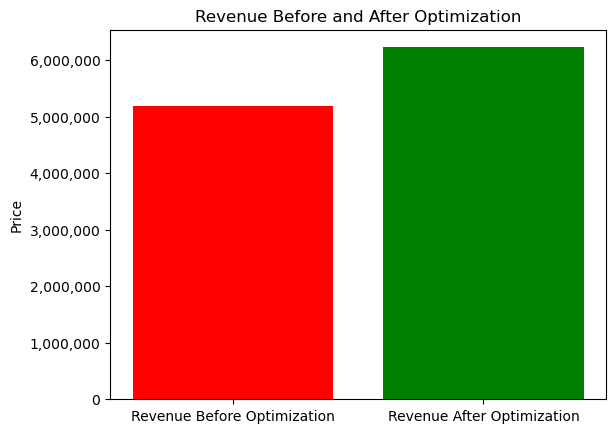

In [174]:
revenue_values = [revenue_before, revenue_after]

# Define labels for the bars
labels = ['Revenue Before Optimization', 'Revenue After Optimization']

# Plotting
plt.bar(labels, revenue_values, color=['red', 'green'])
plt.title('Revenue Before and After Optimization')
plt.ylabel('Price')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [172]:
prices_df = pd.DataFrame({
    'Predicted Prices': predicted_prices,
    'Optimized Prices': optimized_prices
})
prices_df

,Predicted Prices,Optimized Prices
0,13552.966797,16263.560137
1,9231.648438,11077.978110
2,7823.997559,9388.797057
3,8440.580078,10128.696080
4,6439.670410,7727.604480
...,...,...
544,14178.356445,17014.027714
545,10986.011719,13183.214046
546,8604.186523,10325.023814
547,13764.491211,16517.389433


Text(0.5, 1.0, 'Distribution of Predicted and Optimized Prices')

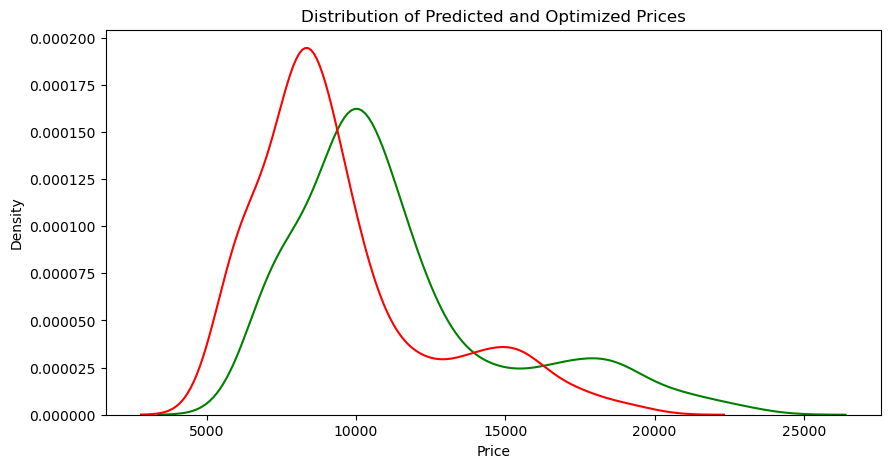

In [175]:
from matplotlib.pyplot import figure

#set size
figure(figsize=(10,5))
       
sns.kdeplot(x=optimized_prices, label='Optimized Prices',color='green')
sns.kdeplot(x=predicted_prices, label='Predicted Prices',color='red')

plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Predicted and Optimized Prices')